# Team 2 Final Project - Health Insurance Cross Sell

## Background information on the overall project:

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

## Problem Statement: 

Our client currently provides for Health Insurance, but they are unsure if it is possible to transition into the automobile insurance sector. In order to determine if this can be done, the Insurance company has tasked our team with developing models that would be able to predict whether a current policy holder would be interested in adding vehicle insurance to their policy.

## Technical Notebook

### Import needed packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import imblearn
from mord import LogisticIT
from imblearn.over_sampling import RandomOverSampler

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from dmba import classificationSummary, gainsChart
from dmba import plotDecisionTree, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

import warnings
warnings.filterwarnings('ignore')

### Import the client provided datasets.  They have already split the data into training and testing sets.

In [2]:
#import the training set and view the first few rows
train = pd.read_csv('C:/Users/Leonard/Desktop/insurance_train.csv')
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


The testing data will be held out so that we can test our models on unseen data.  Therefore, all of our EDA and modeling will take place on the training data.  We will use the entire training data set to build models.  Cross validation will be used for best results.

## Exploratory Data Analysis

### Initial Analysis

First, let us define the variables in our training set.

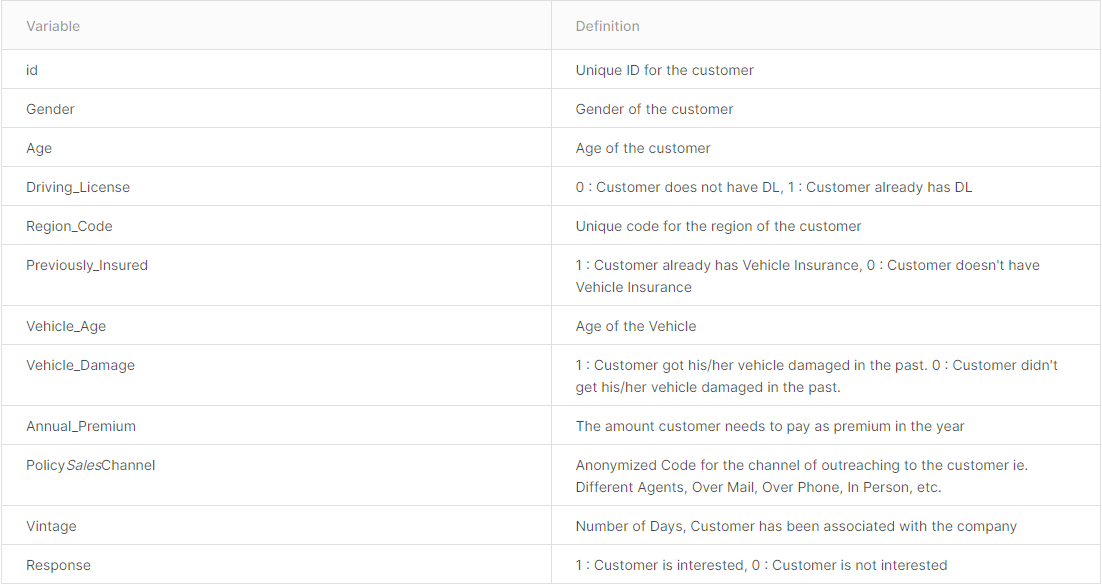

Let's check for missing data.  Missing data can impact analyses, so we want to be sure we do not have missing data, and if we do, handle that appropriately

In [6]:
#check for missing data in the training set
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Great! We have no missing data!  Now let us see what kind of values our data can take on.

In [7]:
#determine the number of unique values for each column
dict=[]
for i in train.columns:
    print(f'{i} has {train[i].nunique()} unique values')

id has 381109 unique values
Gender has 2 unique values
Age has 66 unique values
Driving_License has 2 unique values
Region_Code has 53 unique values
Previously_Insured has 2 unique values
Vehicle_Age has 3 unique values
Vehicle_Damage has 2 unique values
Annual_Premium has 48838 unique values
Policy_Sales_Channel has 155 unique values
Vintage has 290 unique values
Response has 2 unique values


In [14]:
#determine the unique values for the lower count columns
print("Gender can take on:\n", train.Gender.value_counts(), "\n")
print("Driving_License can take on:\n", train.Driving_License.value_counts(), "\n")
print("Previously_Insured can take on:\n", train.Previously_Insured.value_counts(), "\n")
print("Vehicle_Age can take on:\n", train.Vehicle_Age.value_counts(), "\n")
print("Vehicle_Damage can take on:\n", train.Vehicle_Damage.value_counts(), "\n")
print("Response can take on:\n", train.Response.value_counts(), "\n")

Gender can take on:
 Male      206089
Female    175020
Name: Gender, dtype: int64 

Driving_License can take on:
 1    380297
0       812
Name: Driving_License, dtype: int64 

Previously_Insured can take on:
 0    206481
1    174628
Name: Previously_Insured, dtype: int64 

Vehicle_Age can take on:
 1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64 

Vehicle_Damage can take on:
 Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64 

Response can take on:
 0    334399
1     46710
Name: Response, dtype: int64 



We make some observations about the columns here.  First, the Response variable can take on 0 (not interested) or 1 (interested).  We also see that this is very imbalanced.  We also see that Gender is binary: either male or female.  Driving_License is either 0 (no) or 1 (yes).  This is also very imbalanced, but this is something we would expect since most insured individuals are licensed drivers.  Previously_Insured is also binary: 0 (no) and 1 (yes).  Vehicle_Age is categorized into three categories: < 1 year, 1-2 years, > 2 years.  We note that this is an ordinal variable since the order of the values matter.  Finally, Vehicle_Damage is either yes or no.  The variables not mentioned here are continuous as they take on very many values.

### Distrubution Visualizations

We take a look at the frequency distribution of each of our variables

<AxesSubplot:xlabel='Gender', ylabel='count'>

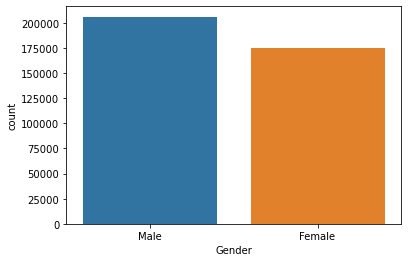

In [15]:
#frequency distribution gender
sns.countplot(data = train, x = 'Gender')

The gender variable seems balanced between male and female customers

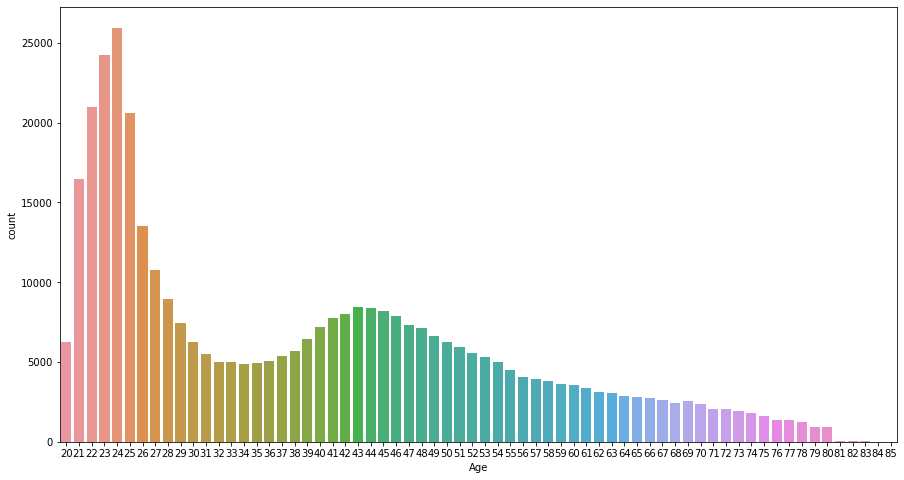

In [20]:
#frequency distribution age
plt.figure(figsize=(15,8))
sns.countplot(data = train, x = 'Age')
plt.show()

The majority of our customers are between the ages of 21 and 27 with a second peak between 38 and 54.

<AxesSubplot:xlabel='Driving_License', ylabel='count'>

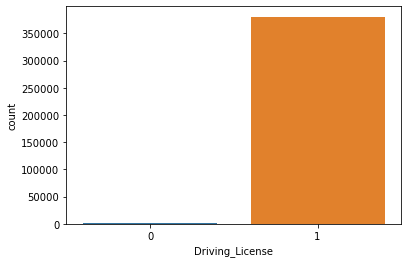

In [21]:
#frequency distribution driving_license
sns.countplot(data = train, x = 'Driving_License')

The vast majority of our customers have a driver's license.  We would expect this as customers who will be interested in car insurance should have a license.

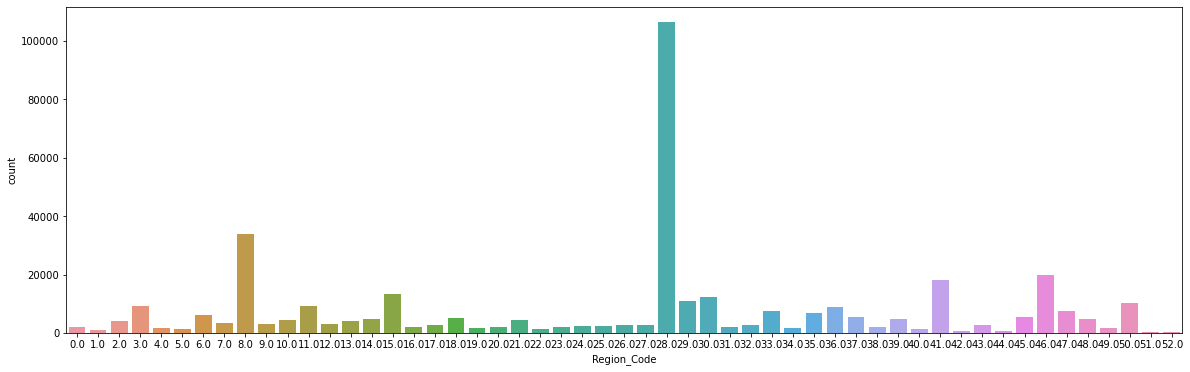

In [25]:
#frequency distribution region_code
plt.figure(figsize=(20,6))
sns.countplot(data = train, x = 'Region_Code')
plt.show()

The majority of our customers fall within region code = .028.

<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

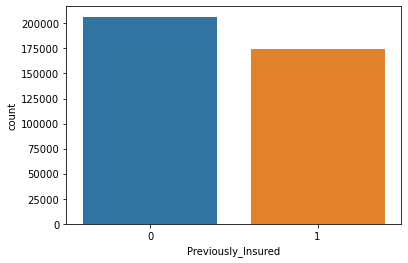

In [26]:
#frequency distribution previously_insured
sns.countplot(data = train, x = 'Previously_Insured')

The previously_insured flag also is relatively even with a slight edge to not previously insured.

<AxesSubplot:xlabel='Vehicle_Age', ylabel='count'>

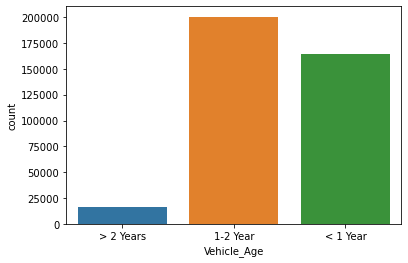

In [27]:
#frequency distribution vehicle_age
sns.countplot(data = train, x = 'Vehicle_Age')

The car age of most of our customers are 2 years or newer.  This bodes well for offering insurance as newer cars tend to be safer.

<AxesSubplot:xlabel='Vehicle_Damage', ylabel='count'>

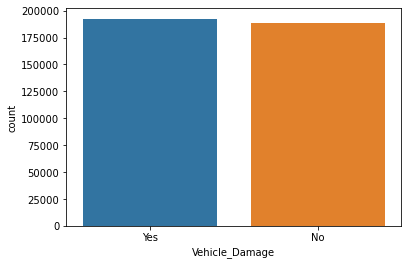

In [28]:
#frequency distribution vehicle_damage
sns.countplot(data = train, x = 'Vehicle_Damage')

The flag for whether the vehicle is damaged or not is roughly even.

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

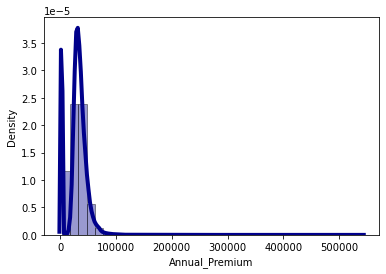

In [38]:
#frequency distribution annual_premium
sns.distplot(train['Annual_Premium'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

The average annual_premium is roughly 30,564.

<AxesSubplot:xlabel='Policy_Sales_Channel', ylabel='Density'>

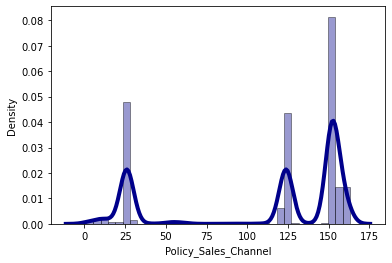

In [49]:
#frequency distribution policy_sales_channel
sns.distplot(train['Policy_Sales_Channel'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

The most frequent policy sales channel is 150 followed by 25 with 125 coming in 3rd.

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

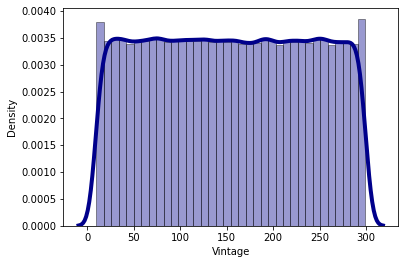

In [48]:
#frequency distribution vintage
sns.distplot(train['Vintage'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

The vintage variable is uniform throughout.  This suggests that the insurance company is pretty good with getting new clients consistently each day.

<AxesSubplot:xlabel='Response', ylabel='count'>

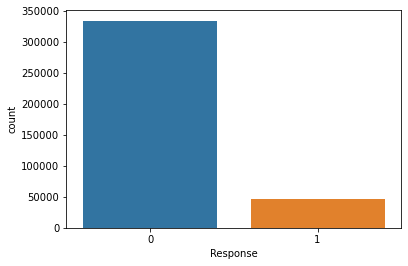

In [50]:
#frequency distribution response
sns.countplot(data = train, x = 'Response')

Finally, we see our response variable is heavily imbalanced where the majority of our customers are not interested in car insurance.  To handle this, we will need to use a technique called random oversampling.

### Univariate Analysis

Many analyses won't work with string values.  Here, we will map Gender, Vehicle_Age and Vehicle_Damage to integer placeholders.  For Gender, we will map male to 0 and female to 1.  For vehicle age, < 1 year will be 0, 1-2 years will be 1 and > 2 years will be 2.  Finally, vehicle damage will be 0 for no and 1 for yes.

In [3]:
#map gender
train['Gender'] = train['Gender'].replace({'Male': 0, 'Female': 1})
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
#map vehicle age
train['Vehicle_Age'] = train['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,Yes,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,No,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,Yes,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,No,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,No,27496.0,152.0,39,0


In [5]:
#map vehicle damage
train['Vehicle_Damage'] = train['Vehicle_Damage'].replace({'No': 0, 'Yes': 1})
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


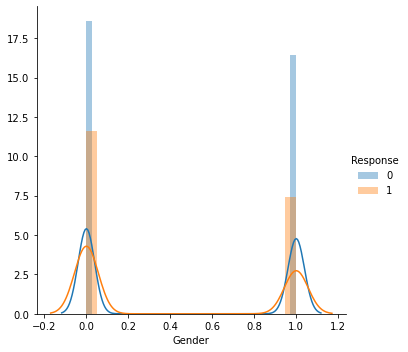

In [26]:
#analysis for Gender
sns.FacetGrid(train, hue='Response', size = 5).map(sns.distplot, "Gender").add_legend()

Here, we see that Males are more likely than Females to be interested in car insurance.

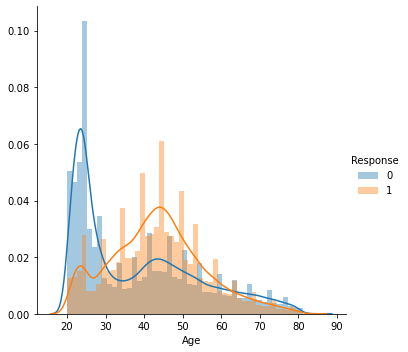

In [12]:
#analysis for Age
sns.FacetGrid(train, hue='Response', size = 5).map(sns.distplot, "Age").add_legend()

Here we see the sweet spot for interested customers is between ages 40 and 50.  Furthermore, we see the sweet spot for customers not interested is between 20 and 30.

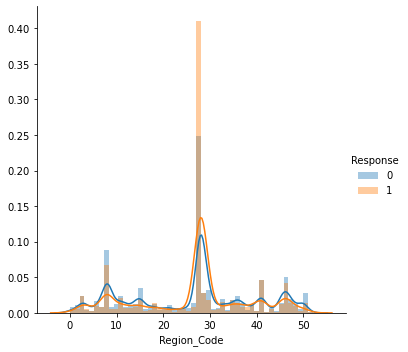

In [14]:
#analysis for Region Code
sns.FacetGrid(train, hue='Response', size = 5).map(sns.distplot, "Region_Code").add_legend()

Here we see that our best region for interested customers is .028.

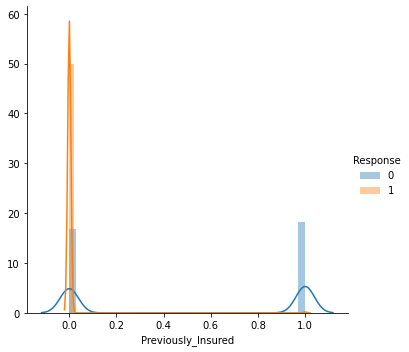

In [15]:
#analysis for Previously Insured
sns.FacetGrid(train, hue='Response', size = 5).map(sns.distplot, "Previously_Insured").add_legend()

We also see that interested customers seem to be not previously insured.

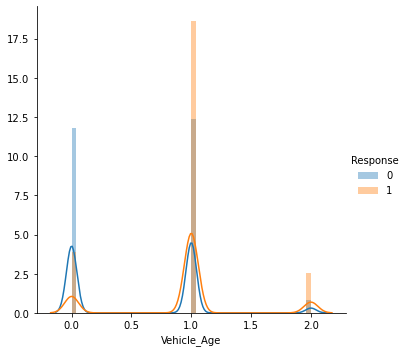

In [27]:
#analysis for vehicle age
sns.FacetGrid(train, hue='Response', size = 5).map(sns.distplot, "Vehicle_Age").add_legend()

Here, we see that customers with vehicle age between 1 and 2 are much more likely to be interested.

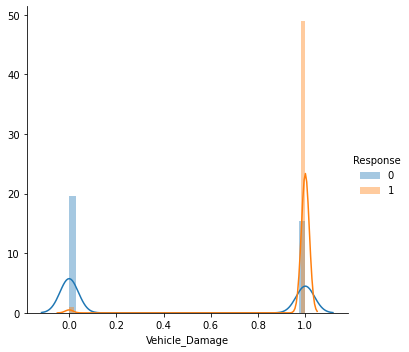

In [28]:
#analysis for vehicle damage
sns.FacetGrid(train, hue='Response', size = 5).map(sns.distplot, "Vehicle_Damage").add_legend()

Finally, we see that customers with vehicle damage are much more likely to be interested in car insurance.

### Bivariate Analysis

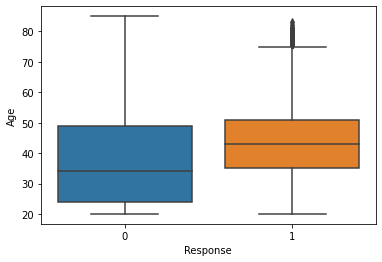

In [30]:
#box plot for response vs age
sns.boxplot(x='Response', y='Age', data=train)
plt.show()

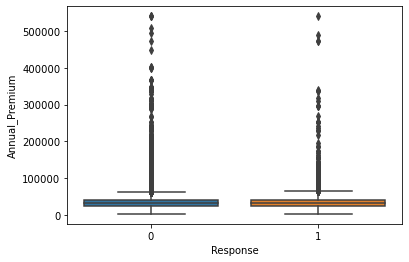

In [35]:
#box plot for response vs annual premium
sns.boxplot(x='Response', y='Annual_Premium', data=train)
plt.show()

This boxplot seems to suggest several outliers present in the annual_premium field.  Further analysis on this later.

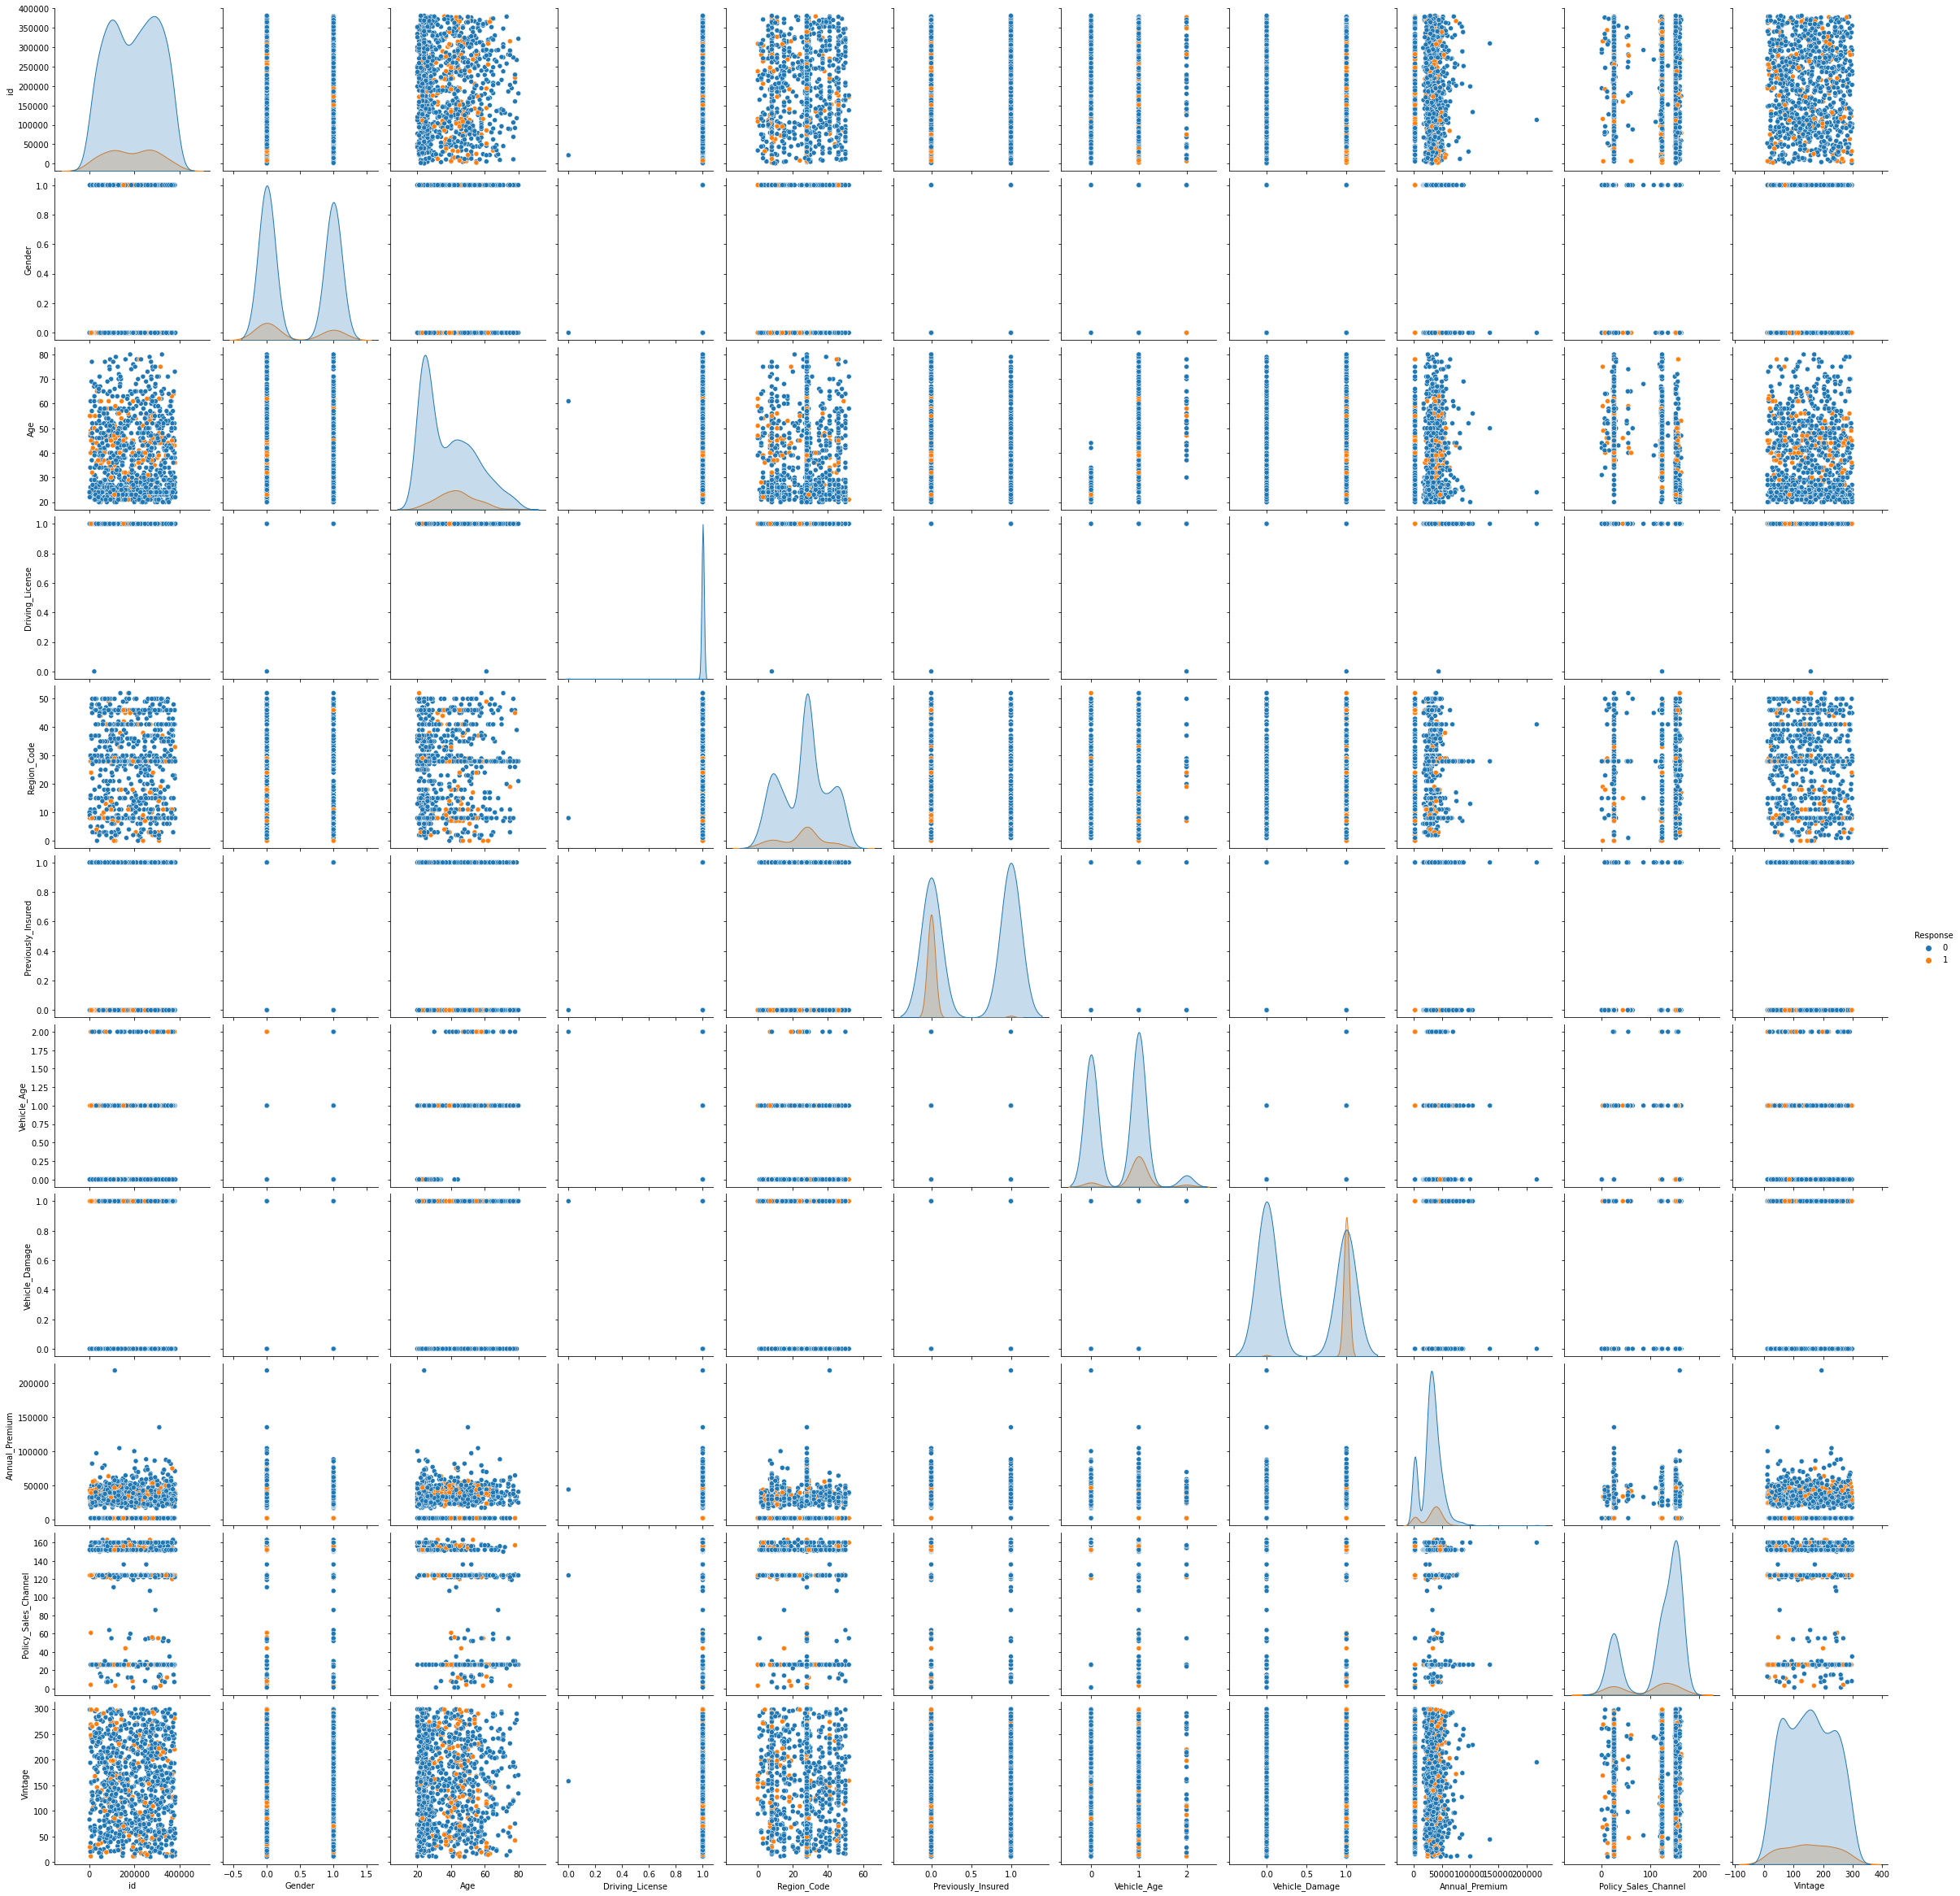

In [10]:
#pairplot for the data
sns.pairplot(train.sample(1000), hue='Response', size=3)
plt.show()

Using seaborn's pairplot, no useful relationships seem to be present within the data.

### Correlation Analysis

Text(0.5, 1.0, 'Correlation Heatmap')

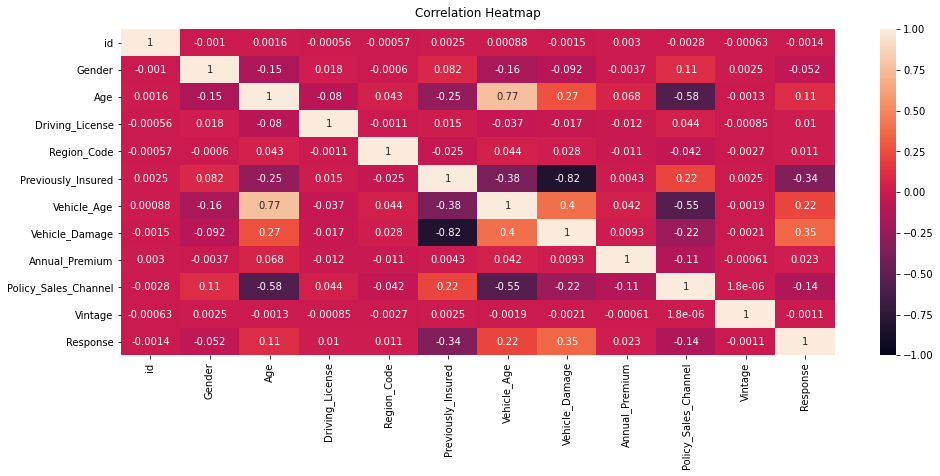

In [11]:
#correlation plot to determine correlations between variables.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

There do seem to be some correlations to be concerned with.  First of all, Vehicle Age and Age seem to have a positive correlation.  Secondly, Previously Insured and Vehicle Damage also seem to have a negative correlation.  We will leave this alone for now.

### Outlier Detection

As we saw above, it appeared that annual premium had some outliers present.  So we will perform additonal analysis on this column

In [6]:
#Calculate the IQR for Annual Premium
apIQR = train.Annual_Premium.quantile(.75) - train.Annual_Premium.quantile(.25)

In [7]:
#determine the rows with outliers and remove them
train_out = train[~(train['Annual_Premium'] >= train.Annual_Premium.quantile(.75) + 1.5*apIQR) | 
                 (train['Annual_Premium'] <= train.Annual_Premium.quantile(.25) - 1.5*apIQR)]

print(train.shape)
print(train_out.shape)

(381109, 12)
(370789, 12)


We found rougly 10,000 rows of outliers (less than 3% of the data), so we remove those rows so that our dataset contains no outliers.  We use this new dataframe, train_out, for further analysis.

## Data Preparation for Modeling

### Define predictor/outcome variables and split data frame into predictor/outcome sets.

In [8]:
#define array of predictors and outcome
predictors = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']
outcome = 'Response'

In [9]:
#create a split of data for training and testing
training, valid = train_test_split(train_out, train_size = 0.6, random_state=1)
print(training.shape, valid.shape)

(222473, 12) (148316, 12)


In [10]:
#split train_out df into two sets
train_X = training[predictors]
train_y = training[outcome]

valid_X = valid[predictors]
valid_y = valid[outcome]

### Random Oversampling

As we saw during the EDA step, our response varaible is heavily imbalanced.  If we leave the data imbalanced, our models will likely just predict the majority class which would not be good for future data.  Therefore, we want to balance this out so we have the same number of yes's as no's.

In [11]:
#oversample the minority class
trainOver = RandomOverSampler(sampling_strategy='minority')

In [12]:
#apply the oversample
X, y = trainOver.fit_resample(train_X, train_y)
print(X.shape, y.shape)

(390584, 10) (390584,)


In [13]:
#display the count of response variables
y.value_counts()

1    195292
0    195292
Name: Response, dtype: int64

We now have a balanced response variable.  We are now ready to begin modeling.  As mentioned earlier, we will use the split training set for modeling and model validation.  The final model will be used to predict the values of the test set provided by the client.

## Modeling

Our approach will be to consider multiple models.  We will run a baseline model of the various models.  The model which outputs the best baseline performance will then be tuned for optimal perfomance and that model will be submitted as the final model.  The models we will consider are Logistic Regression, Neural Networks, Linear Discriminant Analysis, Random Forests and Decision Trees.

### Logistic Regression

In [16]:
#Run the Logistic Regression model
logReg = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=10, max_iter=500, n_jobs=-1)
logReg.fit(X, y)

LogisticRegressionCV(cv=10, max_iter=500, n_jobs=-1)

In [17]:
#Analyze the Logistic Regression model
classificationSummary(valid_y, logReg.predict(valid_X))

Confusion Matrix (Accuracy 0.6425)

       Prediction
Actual     0     1
     0 77823 52519
     1   508 17466


This model yields terrible results.  64% is not what we are shooting for.  Logistic regression is eliminated because of this.

### Neural Network

In [33]:
#Run the Neural Network model
nn = MLPClassifier(hidden_layer_sizes=(11), activation='logistic', solver='lbfgs', random_state=1)
nn.fit(X, y)

MLPClassifier(activation='logistic', hidden_layer_sizes=11, random_state=1,
              solver='lbfgs')

In [34]:
#Analyze the Neural Network model
classificationSummary(valid_y, nn.predict(valid_X))

Confusion Matrix (Accuracy 0.8788)

       Prediction
Actual      0      1
     0 130342      0
     1  17974      0


Neural network yields much better accuracy than Logistic Regression, but as you can see, it doesn't predict any positive values.  For the insurance company, this would be useless.

### Linear Discriminant Analysis

In [35]:
#Run the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [36]:
#Analyze the LDA model
classificationSummary(valid_y, lda.predict(valid_X))

Confusion Matrix (Accuracy 0.6410)

       Prediction
Actual     0     1
     0 77528 52814
     1   430 17544


Just like Linear Regression, LDA does not yield great accuracy and therefore will not be used.

### Decision Tree

In [37]:
#Run the Classification Tree model
classTree = DecisionTreeClassifier(random_state=1)
classTree.fit(X, y)

DecisionTreeClassifier(random_state=1)

In [38]:
#Analyze the Classification Tree model
classificationSummary(valid_y, classTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8284)

       Prediction
Actual      0      1
     0 117914  12428
     1  13021   4953


Our decision tree model performed relatively well.  It yeilded an accuracy of 83% while predicting both positive and negative values.

### Random Forest

In [18]:
#Run the Random Forest model
rf = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)

In [19]:
#Analyze the Random Forest model
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.8482)

       Prediction
Actual      0      1
     0 121147   9195
     1  13315   4659


Random Forest turned out to be our best performing model at 85%.  Therefore, this will be our chosen model to fine tune and try to improve.

## Model and Hyperparameter Tuning

### Grid Searching

In [20]:
#create an initial guess for random forest parameters
param_grid = {
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_split': [10, 20, 30, 40, 0],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}

gridSearch = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X, y)

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.8868053955651168
Initial parameters:  {'max_depth': 25, 'min_impurity_decrease': 0, 'min_samples_split': 10}


In [15]:
#adapt initial grid search
param_grid = {
    'max_depth': list(range(23, 27)),
    'min_samples_split': list(range(8, 12)),
    'min_impurity_decrease': [0, 0.001, 0.0001],
}
gridSearch = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X, y)

print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

Improved score:  0.8938000506943446
Improved parameters:  {'max_depth': 26, 'min_impurity_decrease': 0, 'min_samples_split': 8}


In [21]:
#use the new parameters to rerun the random forest model
rf = RandomForestClassifier(n_estimators=500, random_state=1, max_depth=26, min_impurity_decrease=0, min_samples_split=8,
                            n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(max_depth=26, min_impurity_decrease=0,
                       min_samples_split=8, n_estimators=500, n_jobs=-1,
                       random_state=1)

In [22]:
#Analyze the Random Forest model
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.7891)

       Prediction
Actual      0      1
     0 104969  25373
     1   5900  12074


## Results and Final Model

We ran a variety of models including Logistic Regression, Neural Network, LDA, Decision Trees and Random Forests.  Of these models, Random Forests performed the best with a baseline accuracy of 85%.  After tuning the model and finding the best parameters, we were able to obtain a model that will be useful.  While the accuracy decreased to 79%, we were able to drastically reduce the number of false negatives (predicted negative but actually positive).  This means our model will minimize the number of customers who do not receive the advertisement for car insurance but would actually be interested.  In the next section, we identify the customers who we will send advertisements to.

## Discussions and Conclusions

### Predict the customers who will be interested in car insurance

In [27]:
#import the test set and view the first few rows
test = pd.read_csv('C:/Users/Leonard/Desktop/insurance_test.csv')
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [28]:
#map gender
test['Gender'] = test['Gender'].replace({'Male': 0, 'Female': 1})
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,0,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,0,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,0,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,0,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,0,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [29]:
#map vehicle age
test['Vehicle_Age'] = test['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,0,25,1,11.0,1,0,No,35786.0,152.0,53
1,381111,0,40,1,28.0,0,1,Yes,33762.0,7.0,111
2,381112,0,47,1,28.0,0,1,Yes,40050.0,124.0,199
3,381113,0,24,1,27.0,1,0,Yes,37356.0,152.0,187
4,381114,0,27,1,28.0,1,0,No,59097.0,152.0,297


In [31]:
#map vehicle damage
test['Vehicle_Damage'] = test['Vehicle_Damage'].replace({'No': 0, 'Yes': 1})
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,0,25,1,11.0,1,0,0,35786.0,152.0,53
1,381111,0,40,1,28.0,0,1,1,33762.0,7.0,111
2,381112,0,47,1,28.0,0,1,1,40050.0,124.0,199
3,381113,0,24,1,27.0,1,0,1,37356.0,152.0,187
4,381114,0,27,1,28.0,1,0,0,59097.0,152.0,297


In [33]:
#use the test data to predict which customers will be interested in car insurance.
test['Response'] = rf.predict(test[predictors])

In [34]:
#display the number of customers who will be interested vs not
test['Response'].value_counts()

0    95514
1    31523
Name: Response, dtype: int64

After applying the model to the unseen data, we identified 31,523 customers who we should send mailers to.  We expect that half of those should be interested.  We also expect that only a small subset of the 95,514 customers not sent mailers would have been interested.  We therefore maximize the number of customers who will want car insurance while minimizing the cost of mailing advertisements to the customers.